In [77]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
# Define columns
timestamp_col = 'Timestamp'
time_col = 'Time [min]'
time_col_s = 'Time [s]'
voltage_col = 'Voltage [V]'
current_col = 'Current [A]'
temperature_col = 'Temperature [degC]'
capacity_col = 'Capacity [Ah]'
capacity_cc_col = 'Cumulative_Capacity_Ah'
soc_col = 'SOC [-]'

In [5]:
# Directory paths
raw_data_directory = '../../datasets/LG_dataset/LG_HG2_data'
parsed_data_directory = '../../datasets/LG_dataset/LG_HG2_parsed'
processed_data_directory = '../../datasets/LG_dataset/LG_HG2_processed'

os.makedirs(parsed_data_directory, exist_ok=True)
os.makedirs(processed_data_directory, exist_ok=True)

In [6]:
def parse_raw_data(file_path: str) -> pd.DataFrame:
    with open(file_path) as f:
        lines = f.readlines()

    column_index = lines.index(next(filter(lambda l: 'Time Stamp' in l, lines)))
    column_line = lines[column_index].split(',')
    data_lines = [l.split(',') for l in lines[column_index + 2:]]
    
    abs_timestamp_data = []
    timestamp_data_seconds = []
    for l in data_lines:
        abs_timestamp_data.append(pd.Timestamp(l[column_line.index('Time Stamp')]))
        timestamp_str = [float(s) for s in l[column_line.index('Prog Time')].split(':')]
        timestamp_seconds = timestamp_str[0] * 3600 + timestamp_str[1] * 60 + timestamp_str[2]
        timestamp_data_seconds.append(timestamp_seconds)

    df = pd.DataFrame({
        timestamp_col: abs_timestamp_data,
        time_col: [(t - timestamp_data_seconds[0]) / 60 for t in timestamp_data_seconds],  # Time in minutes
        time_col_s: [(t - timestamp_data_seconds[0]) for t in timestamp_data_seconds],     # Time in seconds
        voltage_col: [float(l[column_line.index('Voltage')]) for l in data_lines],
        current_col: [float(l[column_line.index('Current')]) for l in data_lines],
        temperature_col: [float(l[column_line.index('Temperature')]) for l in data_lines],
        capacity_col: [float(l[column_line.index('Capacity')]) for l in data_lines],
    })

    return df

In [49]:
# Function to create pseudo OCV-SOC interpolation function
def get_pOCV_SOC_interp_fn(file_path: str) -> (interp1d, interp1d):
    df = pd.read_csv(file_path)
    
    # Process discharge data
    df_discharge = df[df[current_col] < 0].copy()
    df_discharge[capacity_col] = df_discharge[capacity_col] - df_discharge[capacity_col].iloc[0]
    df_discharge[soc_col] = 1 - abs(df_discharge[capacity_col] / df_discharge[capacity_col].iloc[-1])
    max_voltage_discharge = df_discharge[voltage_col].max()
    df_discharge = df_discharge[df_discharge[voltage_col] <= max_voltage_discharge]
    discharge_interp = interp1d(df_discharge[voltage_col], df_discharge[soc_col], bounds_error=False, fill_value="extrapolate")

    # Process charge data
    df_charge = df[df[current_col] > 0].copy()
    df_charge[capacity_col] = df_charge[capacity_col] - df_charge[capacity_col].iloc[0]
    df_charge[soc_col] = abs(df_charge[capacity_col]) / df_charge[capacity_col].iloc[-1]
    max_voltage_charge = df_charge[voltage_col].max()
    df_charge = df_charge[df_charge[voltage_col] <= max_voltage_charge]
    charge_interp = interp1d(df_charge[voltage_col], df_charge[soc_col], bounds_error=False, fill_value="extrapolate")

    return charge_interp, discharge_interp

def get_max_capacities(c20_file_path):
    df_c20 = pd.read_csv(c20_file_path)

    # Find the index where the discharge phase ends and the charge phase begins
    charge_start_index = df_c20[df_c20[current_col] > 0].index[0]

    # Split the DataFrame into discharge and charge phases
    df_discharge = df_c20.iloc[:charge_start_index]
    df_charge = df_c20.iloc[charge_start_index:]

    # Calculate max capacities for discharge and charge phases
    max_discharge_capacity = df_discharge[capacity_col].max() - df_discharge[capacity_col].min()
    max_charge_capacity = df_charge[capacity_col].max() - df_charge[capacity_col].min()

    return max_charge_capacity, max_discharge_capacity

def get_initial_soc(df, charge_soc_fn, discharge_soc_fn, current_col, voltage_col):
    initial_voltage = df[voltage_col].iloc[0]

    # Find the index of the first non-zero current
    first_non_zero_index = df[df[current_col] != 0].index[0]
    first_non_zero_current = df[current_col].iloc[first_non_zero_index]

    # Determine SOC based on the sign of the first non-zero current
    if first_non_zero_current < 0:
        return discharge_soc_fn(initial_voltage)
    else:
        return charge_soc_fn(initial_voltage)

In [50]:
def process_file(args):
    csv_file_name, T = args
    try:
        # Ensure directories exist
        parsed_dir = os.path.join(parsed_data_directory, T)
        processed_dir = os.path.join(processed_data_directory, T)
        os.makedirs(parsed_dir, exist_ok=True)
        os.makedirs(processed_dir, exist_ok=True)

        # Parsing raw data
        raw_file_path = os.path.join(raw_data_directory, T, f'{csv_file_name}.csv')
        df = parse_raw_data(raw_file_path)

        # Save parsed data
        parsed_file_path = os.path.join(parsed_dir, f'{csv_file_name}_parsed.csv')
        df.to_csv(parsed_file_path, index=False)

        # Find a C20 file for pOCV-SOC interpolation functions
        c20_file = next((f for f in os.listdir(parsed_dir) if 'C20' in f), None)
        if c20_file:
            c20_file_path = os.path.join(parsed_dir, c20_file)
            # Get pOCV-SOC interpolation functions and max capacities
            charge_soc_fn, discharge_soc_fn = get_pOCV_SOC_interp_fn(c20_file_path)
            max_charge_capacity, max_discharge_capacity = get_max_capacities(c20_file_path)

            df['Time_diff'] = df[time_col_s].diff().fillna(0) / 3600  
            df['Cumulative_Capacity_Ah'] = (df[current_col] * df['Time_diff']).cumsum()

            # Get initial SoC based on the first voltage reading and whether the battery is charging or discharging
            initial_soc = get_initial_soc(df, charge_soc_fn, discharge_soc_fn, current_col, voltage_col)
            df[soc_col] = initial_soc  # Initialize the SoC column with the initial SoC value

            # Calculate cumulative capacity and SoC throughout the dataset
            last_known_soc = initial_soc  # Keep track of the last known SoC value
            df['Cumulative_Capacity_Ah'] = 0.0  # Initialize the cumulative capacity column

            for index, row in df.iterrows():
                # Skip the first row to avoid indexing errors
                if index == 0:
                    continue

                # Calculate the cumulative capacity change
                time_diff = (row[time_col_s] - df.at[index-1, time_col_s]) / 3600
                cumulative_capacity_change = row[current_col] * time_diff
                df.at[index, 'Cumulative_Capacity_Ah'] = df.at[index-1, 'Cumulative_Capacity_Ah'] + cumulative_capacity_change

                # If current is not zero (not in relaxation), update SoC based on the cumulative capacity
                if row[current_col] != 0:  # Assuming relaxation is when current is exactly 0
                    if row[current_col] < 0:  # Discharging
                        soc = last_known_soc - (abs(cumulative_capacity_change) / max_discharge_capacity)
                    else:  # Charging
                        soc = last_known_soc + (cumulative_capacity_change / max_charge_capacity)
                    
                    # Clamp SoC between 0 and 1
                    soc = max(0, min(soc, 1))
                    last_known_soc = soc  # Update the last known SoC
                else:
                    # If in relaxation phase, SoC remains the same as the last known value
                    soc = last_known_soc

                df.at[index, soc_col] = soc
        else:
            print(f'C20 SOC data file missing in directory: {parsed_dir}')

        # Apply EMW smoothing to SoC
        # alpha = 0.1 
        # df[soc_col] = df[soc_col].ewm(alpha=alpha).mean()
        
        df['Rounded_Time'] = df[time_col_s].round().astype(int)
        df_processed = df.drop_duplicates(subset='Rounded_Time')

        # Save processed data with SOC
        processed_file_path = os.path.join(processed_dir, f'{csv_file_name}_processed.csv')
        df_processed.to_csv(processed_file_path, index=False)
        return 1  # Return 1 on successful completion
    
    except Exception as e:
        return 0  # Return 0 on error

In [41]:
def process_c20_files(T):
    try:
        # Ensure directories exist
        parsed_dir = os.path.join(parsed_data_directory, T)
        os.makedirs(parsed_dir, exist_ok=True)
        
        # Find a C20 file in the raw data directory for the specified temperature
        raw_dir = os.path.join(raw_data_directory, T)
        c20_file = next((f for f in os.listdir(raw_dir) if 'C20' in f), None)

        if c20_file:
            raw_c20_file_path = os.path.join(raw_dir, c20_file)
            df = parse_raw_data(raw_c20_file_path)

            # Save parsed C20 data
            parsed_c20_file_path = os.path.join(parsed_dir, c20_file.split(".csv")[0] + "_parsed.csv")
            df.to_csv(parsed_c20_file_path, index=False)

        return 1  # Return 1 on successful completion

    except Exception as e:
        return 0  # Return 0 on error

In [25]:
temperatures = [folder for folder in os.listdir(raw_data_directory) if 'degC' in folder]

In [53]:
temperatures

['40degC', '0degC', 'n20degC', '25degC', '10degC', 'n10degC']

In [43]:
# Process C20 files first for all temperature subfolders3
for T in temperatures:
    process_c20_files(T)


In [44]:
tasks = []
for T in temperatures:
    raw_data_T_directory = os.path.join(raw_data_directory, T)
    csv_files = [f for f in os.listdir(raw_data_T_directory) if f.endswith('.csv')]
    for csv_file in csv_files:
        csv_file_name = csv_file.split(".csv")[0]
        tasks.append((csv_file_name, T))

total_tasks = len(tasks)

In [52]:
for task in tqdm(tasks):
    process_file(task)

100%|██████████| 208/208 [11:22<00:00,  3.28s/it]


In [87]:
df_temp = []
for T in temperatures:
    processed_dir = os.path.join(processed_data_directory, T)
    us06_file_path = next((f for f in os.listdir(processed_dir) if 'US06' in f), None)
    df = pd.read_csv(os.path.join(processed_dir, us06_file_path))
    df_temp.append(df)

In [81]:
df_temp[0]['']

,Timestamp,Time [min],Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],Rounded_Time
0,2018-11-08 09:53:14,0.000000,0.000,4.18936,-0.05108,23.34519,0.00000,0.000000,0.000000,1.005569,0
1,2018-11-08 09:53:14,0.010033,0.602,4.18784,-0.09450,23.34519,-0.00001,0.000029,-0.000015,0.999995,1
2,2018-11-08 09:53:15,0.025017,1.501,4.18767,-0.09450,23.34519,-0.00004,0.000028,-0.000039,0.999987,2
3,2018-11-08 09:53:16,0.041700,2.502,4.18750,-0.09450,23.34519,-0.00006,0.000028,-0.000065,0.999977,3
4,2018-11-08 09:53:17,0.059983,3.599,4.18734,-0.09195,23.34519,-0.00009,0.000028,-0.000093,0.999966,4
...,...,...,...,...,...,...,...,...,...,...,...
1172,2018-11-08 10:12:45,19.525233,1171.514,4.09848,0.00000,24.08130,-0.18981,0.000028,-0.189767,0.927756,1172
1173,2018-11-08 10:12:46,19.541933,1172.516,4.09848,0.00000,24.08130,-0.18981,0.000028,-0.189767,0.927756,1173
1174,2018-11-08 10:12:47,19.558600,1173.516,4.09865,0.00000,24.08130,-0.18981,0.000028,-0.189767,0.927756,1174
1175,2018-11-08 10:12:48,19.575250,1174.515,4.09848,0.00000,24.08130,-0.18981,0.000028,-0.189767,0.927756,1175


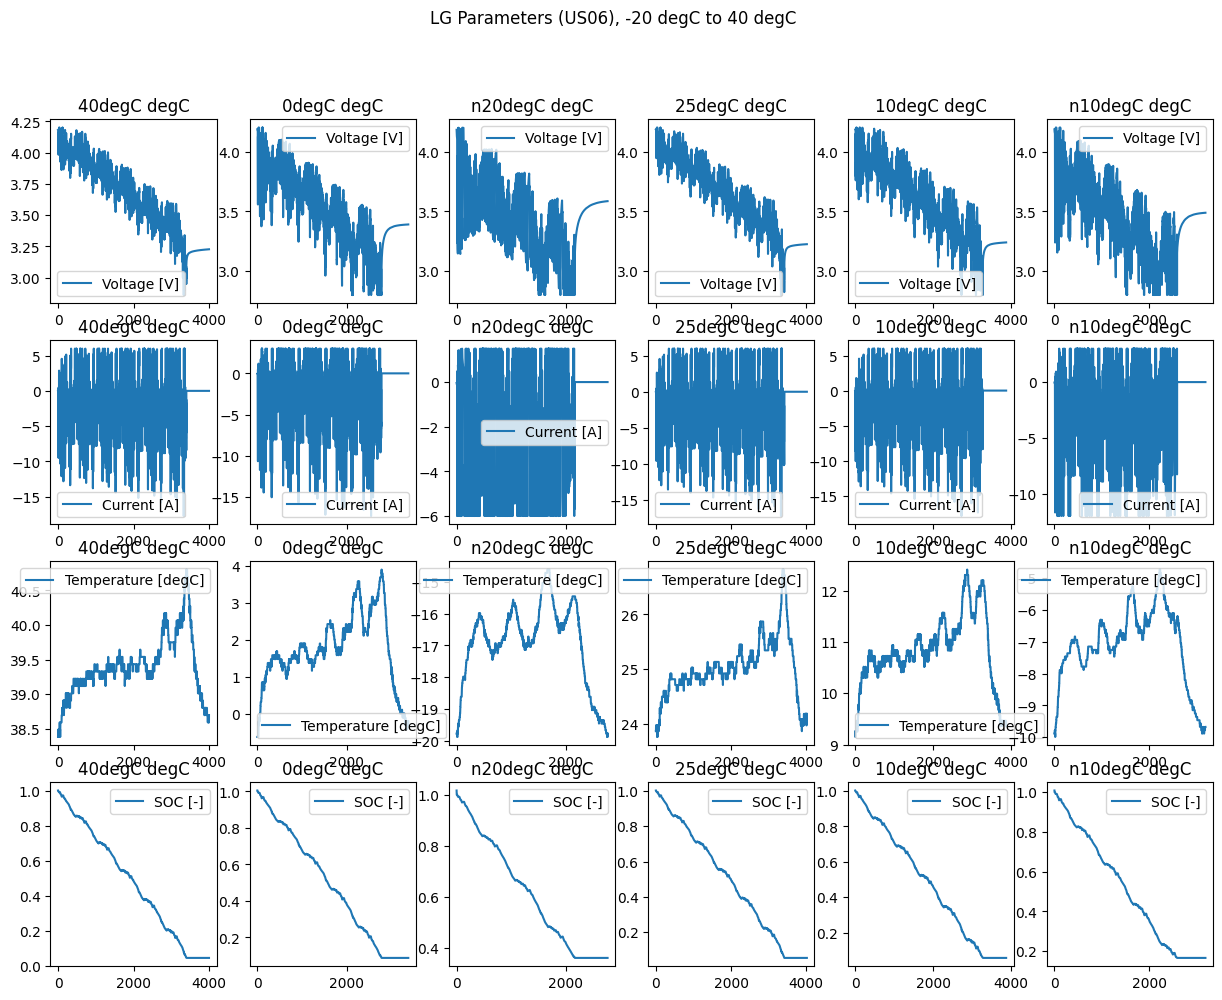

In [88]:
plot_cols = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'SOC [-]']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=len(temperatures), figsize=(15, 11))
fig.suptitle("LG Parameters (US06), -20 degC to 40 degC")

for i, col in enumerate(plot_cols):
    for j in range(len(df_temp)):
        axs[i, j].plot(df_temp[j][col], label=f'{col}')
        axs[i, j].set_title(f'{temperatures[j]} degC')
        axs[i, j].legend()


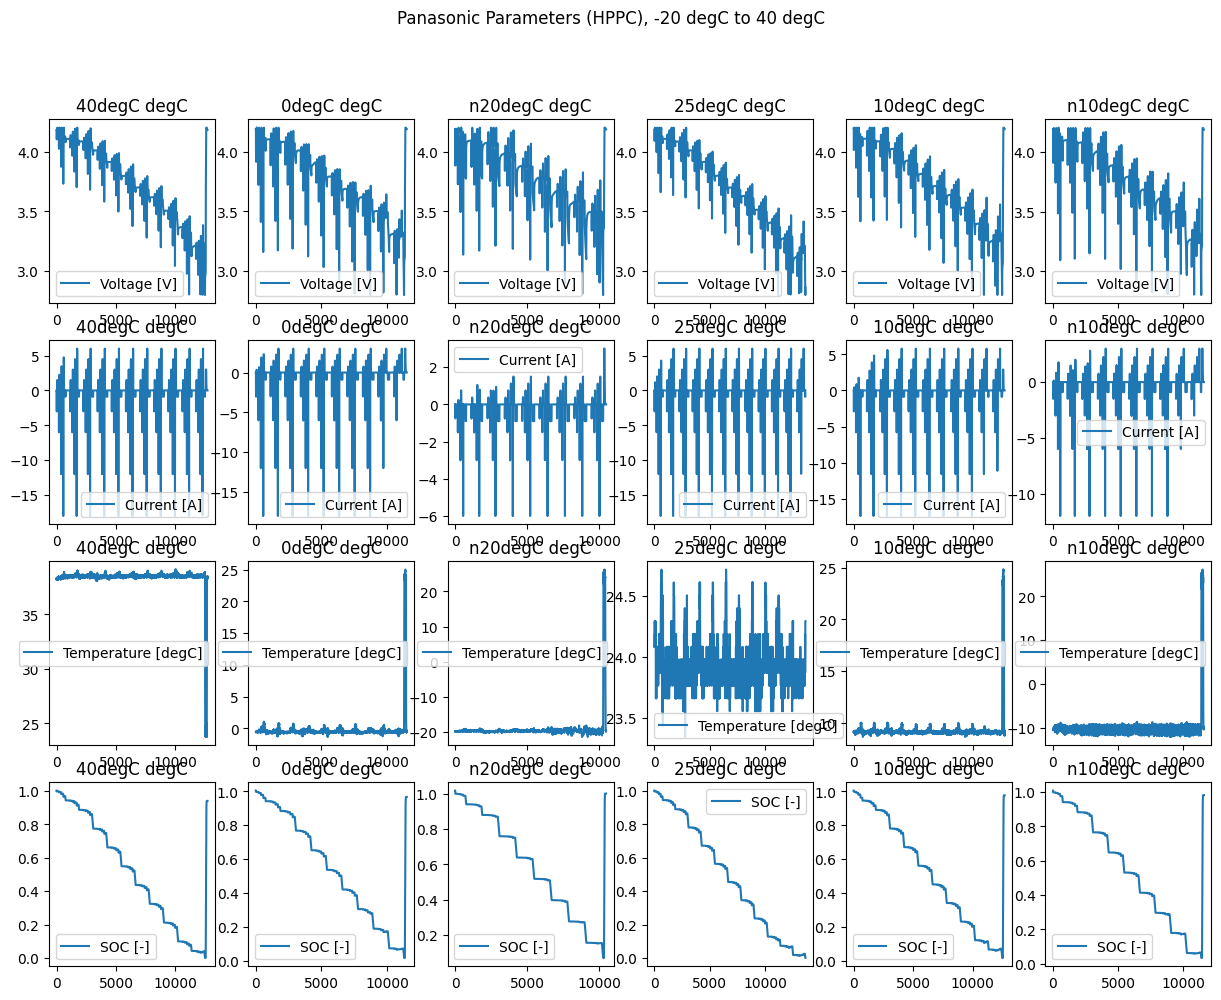

In [72]:
plot_cols = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'SOC [-]']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=len(temperatures), figsize=(15, 11))
fig.suptitle("Panasonic Parameters (HPPC), -20 degC to 40 degC")

for i, col in enumerate(plot_cols):
    for j in range(len(df_temp)):
        axs[i, j].plot(df_temp[j][col], label=f'{col}')
        axs[i, j].set_title(f'{temperatures[j]} degC')
        axs[i, j].legend()

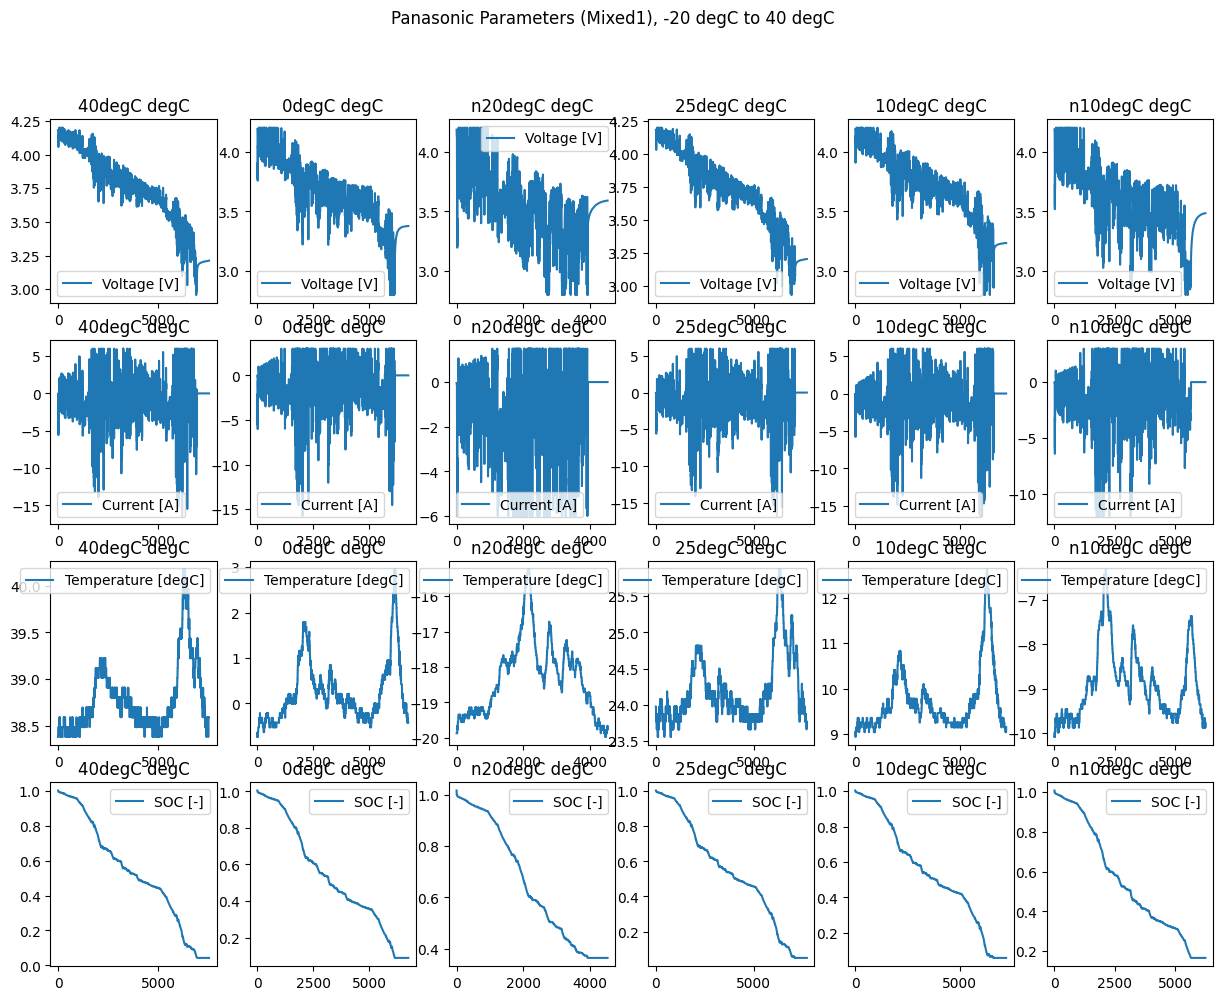

In [74]:
plot_cols = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'SOC [-]']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=len(temperatures), figsize=(15, 11))
fig.suptitle("Panasonic Parameters (Mixed1), -20 degC to 40 degC")

for i, col in enumerate(plot_cols):
    for j in range(len(df_temp)):
        axs[i, j].plot(df_temp[j][col], label=f'{col}')
        axs[i, j].set_title(f'{temperatures[j]} degC')
        axs[i, j].legend()

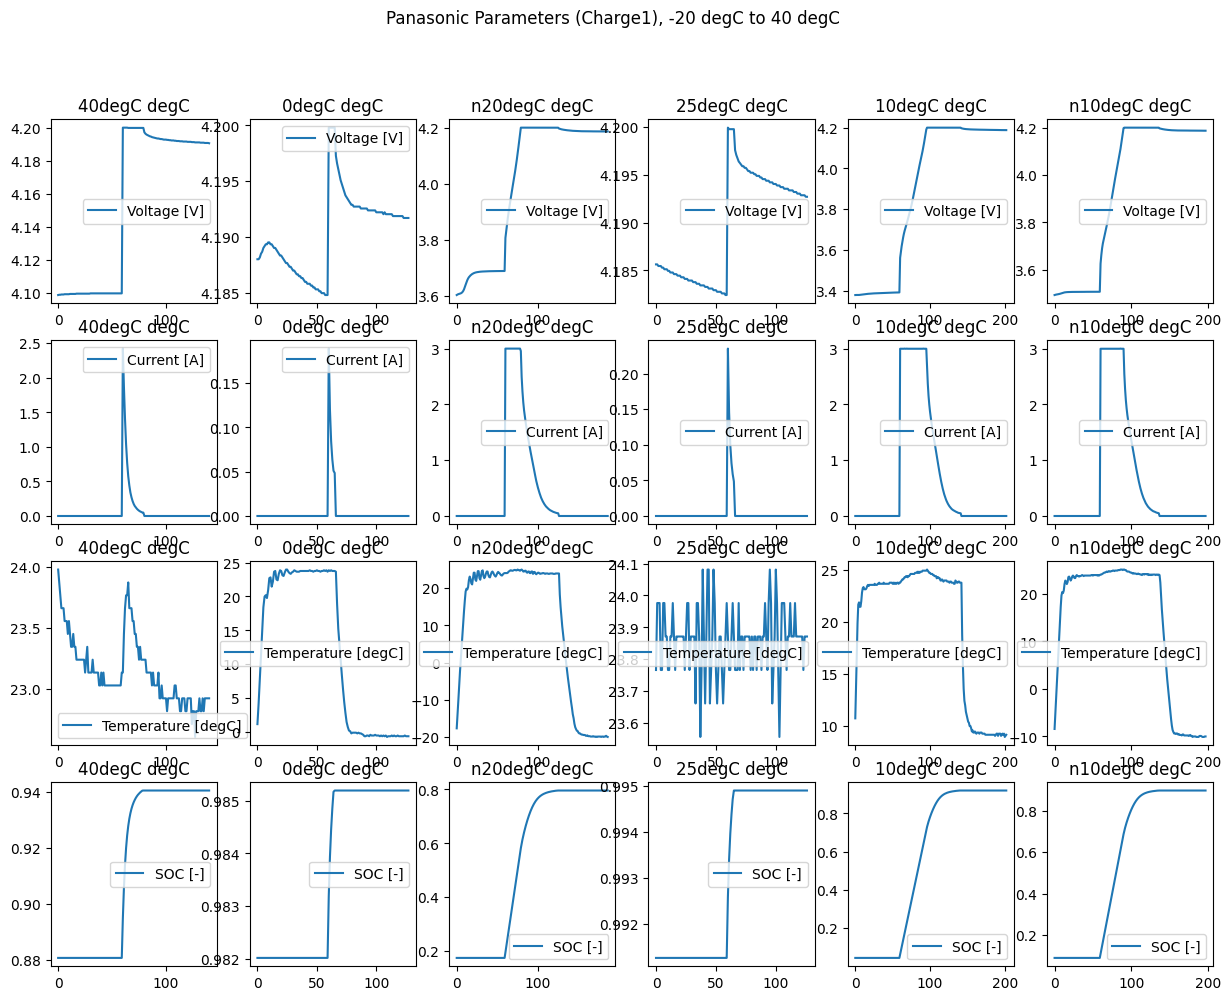

In [76]:
plot_cols = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'SOC [-]']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=len(temperatures), figsize=(15, 11))
fig.suptitle("Panasonic Parameters (Charge1), -20 degC to 40 degC")

for i, col in enumerate(plot_cols):
    for j in range(len(df_temp)):
        axs[i, j].plot(df_temp[j][col], label=f'{col}')
        axs[i, j].set_title(f'{temperatures[j]} degC')
        axs[i, j].legend()